In [ ]:
!pip install gpytorch
!pip install uncertainty-toolbox
!pip install netcal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 28.3 MB/s eta 0:00:00


In [ ]:
# import sys
# if sys.platform.startswith(("linux", "darwin")):
#     !mamba install -q -y -c pyg pyg
#     !mamba install -q -y -c conda-forge pytorch_scatter

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.4 MB/s eta 0:00:00


In [ ]:
!pip install torch_scatter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch_scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=3662080 sha256=0250187f2098548805a4bfb7f3b71a58f1b44018a93c7891a1d1ee23fa79a317
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch_scatter


In [ ]:
import math
import operator
from itertools import chain, product
from functools import partial
from pathlib import Path
from typing import Any, Optional, Callable, Tuple, Dict, Sequence, NamedTuple

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch import Tensor, LongTensor

import random

import torch_geometric
from torch_geometric.transforms import BaseTransform, Compose
from torch_geometric.datasets import QM9
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn.aggr import SumAggregation
import torch_geometric.nn as geom_nn

import matplotlib as mpl
import matplotlib.pyplot as plt
from torch_scatter import scatter

import uncertainty_toolbox as uct

from torch.utils.tensorboard import SummaryWriter

from netcal import manual_seed, cumulative_moments
from netcal.regression import IsotonicRegression, VarianceScaling, GPBeta, GPNormal, GPCauchy
from netcal.metrics import NLL, ENCE, UCE, QCE, PinballLoss
from netcal.presentation import ReliabilityRegression

In [ ]:
def set_seed(seed):
    # Set the seed for the Python random module
    random.seed(seed)

    # Set the seed for NumPy
    np.random.seed(seed)

    # Set the seed for PyTorch (CPU)
    torch.manual_seed(seed)

    # If using a GPU, set the seed for PyTorch (GPU)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.

    # Ensure deterministic behavior for some operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a seed value
seed = 0
set_seed(seed)

In [ ]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [ ]:
def num_heavy_atoms(qm9_data: Data) -> int:
    """Count the number of heavy atoms in a torch geometric
    Data object.

    Parameters
    ----------
    qm9_data : Data
        A pytorch geometric qm9 data object representing a small molecule
         where atomic numbers are stored in a
        tensor-valued attribute `qm9_data.z`

    Returns
    -------
    int
        The number of heavy atoms in the molecule.
    """
    # every atom with atomic number other than 1 is heavy
    return (qm9_data.z != 1).sum()


def complete_edge_index(n: int) -> LongTensor:
    """
    Constructs a complete edge index.

    NOTE: representing complete graphs
    with sparse edge tensors is arguably a bad idea
    due to performance reasons, but for this tutorial it'll do.

    Parameters
    ----------
    n : int
        the number of nodes in the graph.

    Returns
    -------
    LongTensor
        A PyTorch `edge_index` represents a complete graph with n nodes,
        without self-loops. Shape (2, n).
    """
    # filter removes self loops
    edges = list(filter(lambda e: e[0] != e[1], product(range(n), range(n))))
    return torch.tensor(edges, dtype=torch.long).T


def add_complete_graph_edge_index(data: Data) -> Data:
    """
    On top of any edge information already there,
    add a second edge index that represents
    the complete graph corresponding to a  given
    torch geometric data object

    Parameters
    ----------
    data : Data
        The torch geometric data object.

    Returns
    -------
    Data
        The torch geometric `Data` object with a new
        attribute `complete_edge_index` as described above.
    """
    data.complete_edge_index = complete_edge_index(data.num_nodes)
    return data


#
dataset = QM9(
    DATA,
    # Filter out molecules with more than 8 heavy atoms
    # pre_filter=lambda data: num_heavy_atoms(data) < 9,
    # implement point cloud adjacency as a complete graph
    pre_transform=add_complete_graph_edge_index,
)

print(f"Num. examples in QM9 restricted to molecules with at most 8 heavy atoms: {len(dataset)}")

Extracting /content/data/raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


Num. examples in QM9 restricted to molecules with at most 8 heavy atoms: 130831


In [ ]:
data = dataset[0]
# This displays all named data attributes, and their shapes (in the case of tensors), or values (in the case of other data).
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5], complete_edge_index=[2, 20])

In [ ]:
data.pos.round(decimals=2)

tensor([[-0.0100,  1.0900,  0.0100],
        [ 0.0000, -0.0100,  0.0000],
        [ 1.0100,  1.4600,  0.0000],
        [-0.5400,  1.4500, -0.8800],
        [-0.5200,  1.4400,  0.9100]])

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


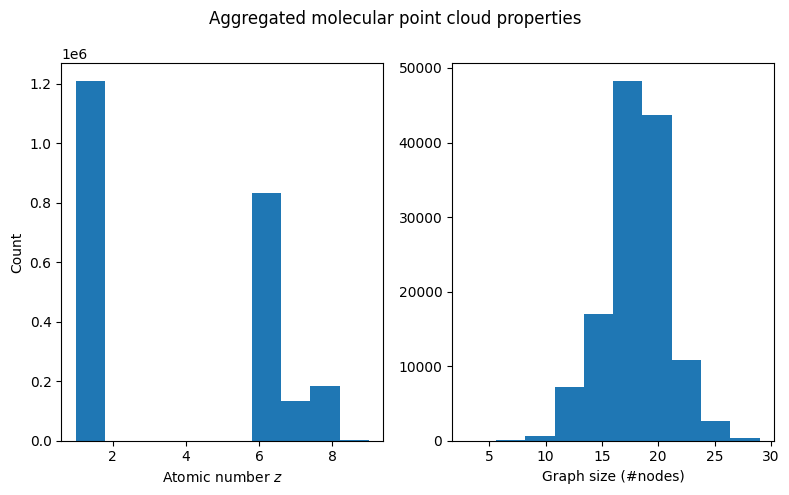

In [ ]:
fig, (ax_atoms, ax_graph_size) = plt.subplots(1, 2, figsize=(8, 5))

# ax_atoms.hist(dataset.data.z[dataset.data.z != 1])
ax_atoms.hist(dataset.data.z)
ax_atoms.set_xlabel("Atomic number $z$")
ax_atoms.set_ylabel("Count")
num_nodes = [dataset[i].num_nodes for i in range(len(dataset))]
ax_graph_size.hist(num_nodes)
ax_graph_size.set_xlabel("Graph size (#nodes)")
fig.suptitle("Aggregated molecular point cloud properties")
fig.tight_layout()

In [ ]:
class QM9DataModule:
    def __init__(
        self,
        train_ratio: float = 0.8,
        val_ratio: float = 0.1,
        test_ratio: float = 0.1,
        target_idx: int = 5,
        seed: float = 420,
    ) -> None:
        """Encapsulates everything related to the dataset

        Parameters
        ----------
        train_ratio : float, optional
            fraction of data used for training, by default 0.8
        val_ratio : float, optional
            fraction of data used for validation, by default 0.1
        test_ratio : float, optional
            fraction of data used for testing, by default 0.1
        target_idx : int, optional
            index of the target (see torch geometric docs), by default 5 (electronic spatial extent)
            (https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html?highlight=qm9#torch_geometric.datasets.QM9)
        seed : float, optional
            random seed for data split, by default 420
        """
        assert sum([train_ratio, val_ratio, test_ratio]) == 1
        self.target_idx = target_idx
        self.dataset = self._load_dataset()
        self.num_examples = len(self.dataset)
        rng = np.random.default_rng(seed)
        self.shuffled_index = rng.permutation(self.num_examples)
        self.train_split = self.shuffled_index[: int(self.num_examples * train_ratio)]
        self.val_split = self.shuffled_index[
            int(self.num_examples * train_ratio) : int(
                self.num_examples * (train_ratio + val_ratio)
            )
        ]
        self.test_split = self.shuffled_index[
            int(self.num_examples * (train_ratio + val_ratio)) : self.num_examples
        ]

        # Calculate mean and std for standardization
        self.mean, self.std = self._calculate_mean_std()

    def _load_dataset(self, transform=None) -> QM9:
        dataset = QM9(
            DATA,
            pre_filter=lambda data: data.num_heavy_atoms < 9,
            pre_transform=self._add_complete_graph_edge_index,
        )
        dataset.data.y = dataset.data.y[:, self.target_idx].view(-1, 1)
        return dataset

    def _calculate_mean_std(self):
        train_data = self.dataset[self.train_split]
        targets = np.concatenate([data.y.numpy() for data in train_data], axis=0)
        mean = targets.mean()
        std = targets.std()
        return mean, std

    def _standardize(self, data):
        data.y = (data.y - self.mean) / self.std
        return data

    def loader(self, split, **loader_kwargs) -> DataLoader:
        dataset = self.dataset[split]
        dataset = [self._standardize(data) for data in dataset]
        return DataLoader(dataset, **loader_kwargs)

    def train_loader(self, **loader_kwargs) -> DataLoader:
        return self.loader(self.train_split, shuffle=True, **loader_kwargs)

    def val_loader(self, **loader_kwargs) -> DataLoader:
        return self.loader(self.val_split, shuffle=False, **loader_kwargs)

    def test_loader(self, **loader_kwargs) -> DataLoader:
        return self.loader(self.test_split, shuffle=False, **loader_kwargs)

    @staticmethod
    def _add_complete_graph_edge_index(data):
        # Implementation of add_complete_graph_edge_index
        return data

In [ ]:
data_module = QM9DataModule()
dataset = data_module._load_dataset()
target = dataset.data.y.flatten().numpy()
print(target)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/dataset.py:249: UserWarning: The `pre_filter` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-fitering technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


[ 35.3641  26.1563  19.0002 ... 780.3553 803.1904 756.3557]


In [ ]:
print(target.shape)

(130831,)


In [ ]:
mean, std = data_module._calculate_mean_std()
print('Mean', mean)
print('Standard deviation', std)

Mean 1189.6278
Standard deviation 280.39124


Text(0.5, 0.98, 'Random data split - target distribution')

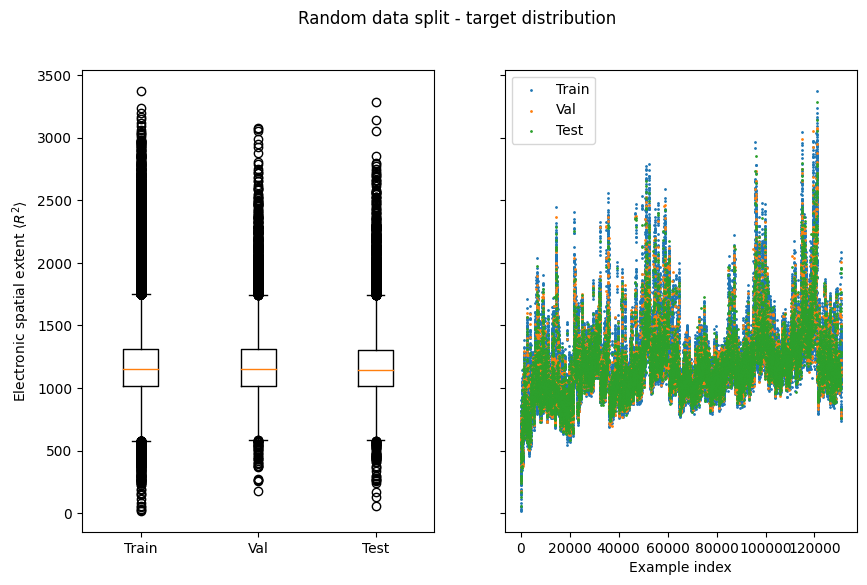

In [ ]:
data_module = QM9DataModule()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
target = data_module._load_dataset().data.y.flatten().numpy()
ax1.boxplot(
    [
        target[data_module.train_split],
        target[data_module.val_split],
        target[data_module.test_split],
    ]
)
ax1.set_xticklabels(["Train", "Val", "Test"])
ax1.set_ylabel("Electronic spatial extent $\langle R^2 \\rangle$")

for label, split in {
    "Train": data_module.train_split,
    "Val": data_module.val_split,
    "Test": data_module.test_split,
}.items():
    ax2.scatter(split, target[split], label=label, s=1)

ax2.set_xlabel("Example index")
ax2.legend()
fig.suptitle("Random data split - target distribution")

In [ ]:
batch_size = 32
train_loader = data_module.train_loader(batch_size=batch_size)
val_loader = data_module.val_loader(batch_size=batch_size)

# Deep Evidential Regression with EGNN

###Dense Normal Gamma

In [ ]:
class DenseNormalGamma(nn.Module):
    def __init__(self, units_in, units_out):
        super(DenseNormalGamma, self).__init__()
        self.units_in = int(units_in)
        self.units_out = int(units_out)
        self.linear = nn.Linear(units_in, 4 * units_out)

    def evidence(self, x):
        softplus = nn.Softplus(beta=1)
        return softplus(x)

    def forward(self, x):
        output = self.linear(x)
        mu, logv, logalpha, logbeta = torch.split(output, self.units_out, dim=-1)
        v = self.evidence(logv) + 1e-5
        alpha = self.evidence(logalpha) + 1
        beta = self.evidence(logbeta) + 1e-5
        return torch.cat(tensors=(mu, v, alpha, beta), dim=-1)

    def compute_output_shape(self):
        return (self.units_in, 4 * self.u)

### Loss Function

In [ ]:
def NIG_NLL(y, gamma, v, alpha, beta, reduce=True):
    twoBlambda = 2*beta*(1+v)
    nll = 0.5*torch.log(np.pi/v)  \
        - alpha*torch.log(twoBlambda)  \
        + (alpha+0.5) * torch.log(v*(y-gamma)**2 + twoBlambda)  \
        + torch.lgamma(alpha)  \
        - torch.lgamma(alpha+0.5)

    return torch.mean(nll) if reduce else nll

def KL_NIG(mu1, v1, a1, b1, mu2, v2, a2, b2):
    KL = 0.5*(a1-1)/b1 * (v2*torch.square(mu2-mu1))  \
        + 0.5*v2/v1  \
        - 0.5*torch.log(torch.abs(v2)/torch.abs(v1))  \
        - 0.5 + a2*torch.log(b1/b2)  \
        - (torch.lgamma(a1) - torch.lgamma(a2))  \
        + (a1 - a2)*torch.digamma(a1)  \
        - (b1 - b2)*a1/b1
    return KL

def NIG_Reg(y, gamma, v, alpha, beta, omega=0.01, reduce=True, kl=False):
    error = torch.abs(y-gamma)

    if kl:
        kl = KL_NIG(gamma, v, alpha, beta, gamma, omega, 1+omega, beta)
        reg = error*kl
    else:
        evi = 2*v+(alpha)
        reg = error*evi

    return torch.mean(reg) if reduce else reg


def EvidentialRegression(y_true, evidential_output, coeff=1.0):
    gamma, v, alpha, beta = torch.split(evidential_output, int(evidential_output.shape[-1]/4), dim=-1)
    loss_nll = NIG_NLL(y_true, gamma, v, alpha, beta)
    loss_reg = NIG_Reg(y_true, gamma, v, alpha, beta)
    return loss_nll + coeff * loss_reg

### EGNN with DNG

In [ ]:
class EquivariantMPLayer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        act: nn.Module,
    ) -> None:
        super().__init__()
        self.act = act
        self.residual_proj = nn.Linear(in_channels, hidden_channels, bias=False)

        # Messages will consist of two (source and target) node embeddings and a scalar distance
        message_input_size = 2 * in_channels + 1

        # equation (3) "phi_l" NN
        self.message_mlp = nn.Sequential(
            nn.Linear(message_input_size, hidden_channels),
            act,
        )
        # equation (4) "psi_l" NN
        self.node_update_mlp = nn.Sequential(
            nn.Linear(in_channels + hidden_channels, hidden_channels),
            act,
        )

    def node_message_function(
        self,
        source_node_embed: Tensor,  # h_i
        target_node_embed: Tensor,  # h_j
        node_dist: Tensor,  # d_ij
    ) -> Tensor:
        # implements equation (3)
        message_repr = torch.cat((source_node_embed, target_node_embed, node_dist), dim=-1)
        return self.message_mlp(message_repr)

    def compute_distances(self, node_pos: Tensor, edge_index: LongTensor) -> Tensor:
        row, col = edge_index
        xi, xj = node_pos[row], node_pos[col]
        # relative squared distance
        # implements equation (2) ||X_i - X_j||^2
        rsdist = (xi - xj).pow(2).sum(1, keepdim=True)
        return rsdist

    def forward(
        self,
        node_embed: Tensor,
        node_pos: Tensor,
        edge_index: Tensor,
    ) -> Tensor:
        row, col = edge_index
        dist = self.compute_distances(node_pos, edge_index)

        # compute messages "m_ij" from  equation (3)
        node_messages = self.node_message_function(node_embed[row], node_embed[col], dist)

        # message sum aggregation in equation (4)
        aggr_node_messages = scatter(node_messages, col, dim=0, reduce="sum")

        # compute new node embeddings "h_i^{l+1}"
        # (implements rest of equation (4))
        new_node_embed = self.residual_proj(node_embed) + self.node_update_mlp(
            torch.cat((node_embed, aggr_node_messages), dim=-1)
        )

        return new_node_embed


class DER_EGNN(nn.Module):
    def __init__(
        self,
        hidden_channels: int,
        final_embedding_size: Optional[int] = None,
        target_size: int = 1,
        num_mp_layers: int = 7,
    ) -> None:
        super().__init__()
        if final_embedding_size is None:
            final_embedding_size = hidden_channels

        # non-linear activation func.
        # usually configurable, here we just use Relu for simplicity
        self.act = nn.SiLU()

        # equation (1) "psi_0"
        self.f_initial_embed = nn.Embedding(100, hidden_channels)

        # create stack of message passing layers
        self.message_passing_layers = nn.ModuleList()
        channels = [hidden_channels] * (num_mp_layers) + [final_embedding_size]
        for d_in, d_out in zip(channels[:-1], channels[1:]):
            layer = EquivariantMPLayer(d_in, d_out, self.act)
            self.message_passing_layers.append(layer)

        # modules required for readout of a graph-level
        # representation and graph-level property prediction
        self.aggregation = SumAggregation()
        self.f_predict = nn.Sequential(
            nn.Linear(final_embedding_size, final_embedding_size),
            self.act,
            nn.Linear(final_embedding_size, final_embedding_size),
        )
        self.DNG = DenseNormalGamma(final_embedding_size, 1)

    def encode(self, data: Data) -> Tensor:
        # theory, equation (1)
        node_embed = self.f_initial_embed(data.z)
        # print('f_initial_embed', node_embed.shape)
        # message passing
        # theory, equation (3-4)
        for mp_layer in self.message_passing_layers:
            # NOTE here we use the complete edge index defined by the transform earlier on
            # to implement the sum over $j \neq i$ in equation (4)
            node_embed = mp_layer(node_embed, data.pos, data.complete_edge_index)
        # print('message passing layers', node_embed.shape)
        return node_embed

    def _predict(self, node_embed, batch_index) -> Tensor:
        aggr = self.aggregation(node_embed, batch_index)
        # return aggr
        return self.f_predict(aggr)

    def forward(self, data: Data) -> Tensor:
        node_embed = self.encode(data)
        # print(node_embed.shape)
        pred_egnn = self._predict(node_embed, data.batch)
        pred_der_egnn = self.DNG(pred_egnn)
        # return pred_egnn
        return pred_der_egnn

In [ ]:
def EvidentialRegressionLoss(true, pred):
    return EvidentialRegression(true, pred, coeff=1e-2)

In [ ]:
criterion = EvidentialRegressionLoss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# model = DER_EGNN(hidden_channels=64, num_mp_layers=2).to(device)
# print(model)

In [ ]:
# def total_absolute_error_DER(pred: Tensor, target: Tensor, batch_dim: int = 0) -> Tensor:
#     """Total absolute error, i.e. sums over batch dimension.

#     Parameters
#     ----------
#     pred : Tensor
#         batch of model predictions
#     target : Tensor
#         batch of ground truth / target values
#     batch_dim : int, optional
#         dimension that indexes batch elements, by default 0

#     Returns
#     -------
#     Tensor
#         total absolute error
#     """
#     mu, v, alpha, beta = np.split(pred.detach().numpy(), 4, axis=-1)
#     return np.abs((mu * std - target.detach().numpy() * std)).sum(axis = batch_dim)

In [ ]:
def total_absolute_error_DER_t(pred: torch.Tensor, target: torch.Tensor, batch_dim: int = 0) -> torch.Tensor:
    """Total absolute error, i.e., sums over the batch dimension.

    Parameters
    ----------
    pred : torch.Tensor
        Batch of model predictions.
    target : torch.Tensor
        Batch of ground truth / target values.
    batch_dim : int, optional
        Dimension that indexes batch elements, by default 0.

    Returns
    -------
    torch.Tensor
        Total absolute error.
    """
    # Assuming pred is concatenated in the last dimension with mu, v, alpha, beta
    mu, v, alpha, beta = torch.split(pred, pred.shape[-1] // 4, dim=-1)

    # Compute total absolute error
    error = torch.abs(mu * std - target * std).sum(dim=batch_dim)

    return error.sum()  # Return a scalar value



In [ ]:
def run_epoch_DER(
    model: nn.Module,
    loader: DataLoader,
    criterion: Callable[[Tensor, Tensor], Tensor],
    pbar: Optional[Any] = None,
    optim: Optional[torch.optim.Optimizer] = None,
) -> Tuple[float, float]:
    """Run a single epoch."""
    def step_DER(data_batch: Data) -> Tuple[float, float]:
        """Perform a single train/val step on a data batch."""
        pred = model.forward(data_batch)
        target = data_batch.y
        loss = criterion(target, pred)
        if optim is not None:
            optim.zero_grad()
            loss.backward()
            optim.step()
        return loss.detach().item(), total_absolute_error_DER_t(pred.detach(), target.detach())

    if optim is not None:
        model.train()
        model.requires_grad_(True)
    else:
        model.eval()
        model.requires_grad_(False)

    total_loss = 0
    total_mae = 0
    for data in loader:
        data = data.to(device)
        loss, mae = step_DER(data)
        total_loss += loss * data.num_graphs
        total_mae += mae
        if pbar is not None:
            pbar.update(1)

    return total_loss / len(loader.dataset), total_mae / len(loader.dataset)

def train_model_DER(
    data_module: QM9DataModule,
    model: nn.Module,
    num_epochs: int = 30,
    lr: float = 3e-4,
    batch_size: int = 64,
    weight_decay: float = 1e-8,
    best_model_path: Path = Path("trained_model.pth"),
) -> Dict[str, Any]:
    """Takes data and model as input and runs training, collecting additional validation metrics while doing so."""
    train_loader = data_module.train_loader(batch_size=batch_size)
    val_loader = data_module.val_loader(batch_size=batch_size)

    optim = torch.optim.Adam(model.parameters(), lr, weight_decay=weight_decay)
    loss_fn = EvidentialRegressionLoss

    best_val_mae = float("inf")

    result = {
        "model": model,
        "path_to_best_model": best_model_path,
        "train_loss": np.full(num_epochs, float("nan")),
        "val_loss": np.full(num_epochs, float("nan")),
        "train_mae": np.full(num_epochs, float("nan")),
        "val_mae": np.full(num_epochs, float("nan")),
    }

    def update_statistics(i_epoch: int, **kwargs: float):
        for key, value in kwargs.items():
            result[key][i_epoch] = value

    def desc(i_epoch: int) -> str:
        return " | ".join(
            [f"Epoch {i_epoch + 1:3d} / {num_epochs}"]
            + [
                f"{key}: {value[i_epoch]:8.2f}"
                for key, value in result.items()
                if isinstance(value, np.ndarray)
            ]
        )

    for i_epoch in range(num_epochs):
        progress_bar = tqdm(total=len(train_loader) + len(val_loader))
        try:
            progress_bar.set_description(desc(i_epoch))

            train_loss, train_mae = run_epoch_DER(model, train_loader, loss_fn, progress_bar, optim)
            val_loss, val_mae = run_epoch_DER(model, val_loader, loss_fn, progress_bar)
            # print('Training:')
            # print(train_loss, train_mae)
            # print('Validation')
            # print(val_loss, val_mae)

            update_statistics(
                i_epoch,
                train_loss=train_loss,
                val_loss=val_loss,
                train_mae=train_mae,
                val_mae=val_mae,
            )

            progress_bar.set_description(desc(i_epoch))

            if val_mae < best_val_mae:
                best_val_mae = val_mae
                torch.save(model.state_dict(), best_model_path)
        finally:
            progress_bar.close()

    return result

In [ ]:
model = DER_EGNN(hidden_channels=64, num_mp_layers=3).to(device)

egnn_train_result = train_model_DER(
    data_module,
    model,
    num_epochs=100,
    lr=2e-4,
    batch_size=32,
    weight_decay=1e-8,
    best_model_path=DATA.joinpath("trained_egnn_der.pth"),
)

Epoch   1 / 100 | train_loss:    -0.77 | val_loss:    -1.42 | train_mae:    35.21 | val_mae:    13.45: 100%|██████████| 3680/3680 [00:52<00:00, 70.22it/s] 
Epoch   2 / 100 | train_loss:    -1.80 | val_loss:    -1.14 | train_mae:     9.11 | val_mae:     9.73: 100%|██████████| 3680/3680 [00:47<00:00, 76.87it/s] 
Epoch   3 / 100 | train_loss:    -2.17 | val_loss:    -2.14 | train_mae:     6.42 | val_mae:     5.41: 100%|██████████| 3680/3680 [00:46<00:00, 78.82it/s] 
Epoch   4 / 100 | train_loss:    -2.31 | val_loss:    -2.69 | train_mae:     5.54 | val_mae:     3.79: 100%|██████████| 3680/3680 [00:47<00:00, 77.81it/s] 
Epoch   5 / 100 | train_loss:    -2.49 | val_loss:    -2.61 | train_mae:     4.65 | val_mae:     4.70: 100%|██████████| 3680/3680 [00:47<00:00, 78.19it/s] 
Epoch   6 / 100 | train_loss:    -2.59 | val_loss:    -1.76 | train_mae:     4.21 | val_mae:     6.35: 100%|██████████| 3680/3680 [00:46<00:00, 78.59it/s] 
Epoch   7 / 100 | train_loss:    -2.73 | val_loss:    -2.51 | tr

In [ ]:
model = model.to('cpu')

In [ ]:
@torch.no_grad()
def test_model_DER(model: nn.Module, data_module: QM9DataModule) -> Tuple[float, Tensor, Tensor]:
    """
    Test a model.

    Parameters
    ----------
    model : nn.Module
        a trained model
    data_module : QM9DataModule
        a data module as defined earlier
        from which we'll get the test data

    Returns
    -------
    _Tuple[float, Tensor, Tensor]
        Test MAE, and model predictions & targets for further processing
    """
    test_mae = 0
    preds, targets = [], []
    loader = data_module.test_loader()
    for data in loader:
        pred = model(data)
        mu, v, alpha, beta = np.split(pred.detach().numpy(), 4, axis=-1)
        target = data.y
        preds.append(torch.from_numpy(mu))
        targets.append(target)
        test_mae += total_absolute_error_DER_t(pred.detach(), target.detach()).item()

    test_mae = test_mae / len(data_module.test_split)

    return test_mae, torch.cat(preds, dim=0), torch.cat(targets, dim=0)


In [ ]:
egnn_model = egnn_train_result["model"]
egnn_model.load_state_dict(torch.load(egnn_train_result["path_to_best_model"]))
egnn_test_mae, egnn_preds, egnn_targets = test_model_DER(egnn_model, data_module)

<ipython-input-31-f141f7cdf927>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  egnn_model.load_state_dict(torch.load(egnn_train_result["path_to_best_model"]))


In [ ]:
egnn_test_mae

0.5784075383577543

In [ ]:
def calculate_predictions(data_module, model, mode='test'):
    assert mode in ['val', 'test'], "Mode should be either 'val' or 'test'"

    loader = data_module.val_loader() if mode == 'val' else data_module.test_loader()

    targets = []
    preds = []

    for data in loader:
        pred = model(data)
        target = data.y
        preds.append(pred)
        targets.append(target)

    preds = torch.cat(preds, dim=0)
    targets = torch.cat(targets, dim=0)

    mu, v, alpha, beta = np.split(preds.detach().numpy(), 4, axis=-1)
    mu = mu[:, 0]
    var_ep = np.sqrt(beta / (v * (alpha - 1))) * std
    var_al = np.sqrt(beta / ((alpha - 1))) * std
    var = np.sqrt(var_ep**2 + var_al**2)

    targets = np.ravel(targets.numpy()) * std + mean
    mu = np.ravel(mu) * std + mean
    var = np.ravel(var)
    var_al = np.ravel(var_al)
    var_ep = np.ravel(var_ep)

    return targets, mu, var, var_al, var_ep

In [ ]:
targets_test, mu_test, var_test, var_al_test, var_ep_test = calculate_predictions(data_module, model, mode='test')

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

In [ ]:
# Plot settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# mpl.rcParams['figure.figsize'] = [7.8,5.9]
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 13
mpl.rcParams['legend.fontsize'] = 15

plt.style.use('seaborn-white')
# sns.set(color_codes=True)

legend_settings = {'loc':'upper center', 'ncol':3, 'frameon':True, 'facecolor':'white',
                   'framealpha':0.8, 'bbox_to_anchor':(0.5, 1.11)}

<ipython-input-52-28961fa4fab8>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


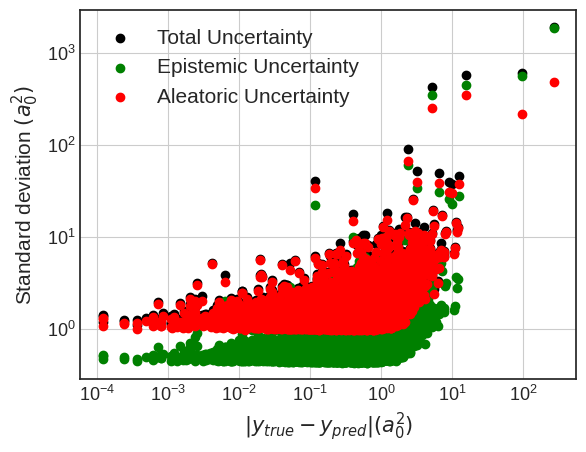

In [ ]:
plt.scatter(np.abs(targets_test - mu_test), var_test, c='k', label='Total Uncertainty')
plt.scatter(np.abs(targets_test - mu_test), var_ep_test, c='g', label='Epistemic Uncertainty')
plt.scatter(np.abs(targets_test - mu_test), var_al_test, c='r', label='Aleatoric Uncertainty')
plt.grid()
plt.xlabel('$|y_{true} - y_{pred}| (a_{0}^2)$')
plt.ylabel('Standard deviation $(a_{0}^2)$')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.savefig('Uncertainty_estimates_QM9_DER.png', dpi=600, bbox_inches='tight')
# plt.show()

In [ ]:
np.savez('DER_QM9_test_0.01.npz', preds = mu_test, targets = targets_test, std=var_test, std_al=var_al_test, std_ep=var_ep_test)

###Aleatoric

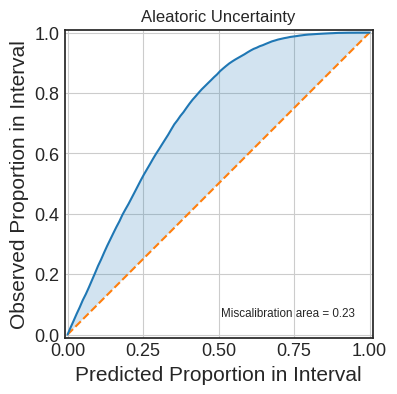

In [ ]:
# Plot average calibration
uct.viz.plot_calibration(mu_test, var_al_test, targets_test)
plt.gcf().set_size_inches(4, 4)
plt.title('Aleatoric Uncertainty')
plt.grid()
plt.show()

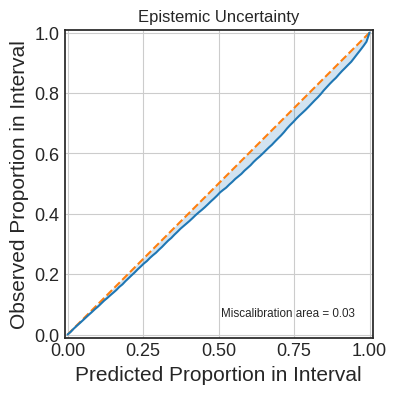

In [ ]:
# Plot average calibration
uct.viz.plot_calibration(mu_test, var_ep_test, targets_test)
plt.gcf().set_size_inches(4, 4)
plt.title('Epistemic Uncertainty')
plt.grid()
plt.show()

Text(0.5, 1.0, 'Total Uncertainty')

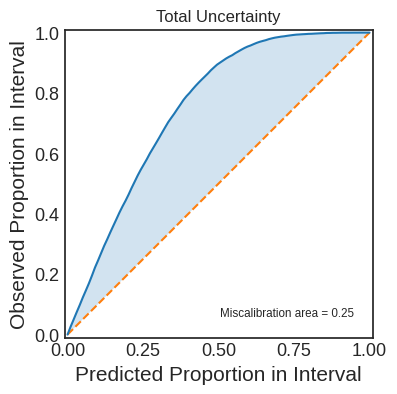

In [ ]:
uct.viz.plot_calibration(mu_test, var_test, targets_test)
plt.gcf().set_size_inches(4, 4)
plt.title('Total Uncertainty')
# plt.grid()
# plt.show()
# plt.savefig('Calibration_QM9_DER.png', dpi=600, bbox_inches='tight')

In [ ]:
unct_metrics_al = uct.metrics.get_all_metrics(mu_test, var_test, targets_test)

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.578
  RMSE          2.657
  MDAE          0.401
  MARPD         0.061
  R2            1.000
  Correlation   1.000
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.278
  Mean-absolute Calibration Error       0.247
  Miscalibration Area                   0.250
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.253
     Group Size: 0.56 -- Calibration Error: 0.250
     Group Size: 1.00 -- Calibration Error: 0.247
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.285
     Group Size: 0.56 -- Calibration Error: 0.280
     Group Size: 1.00 -- Calibration Error: 0.278
================

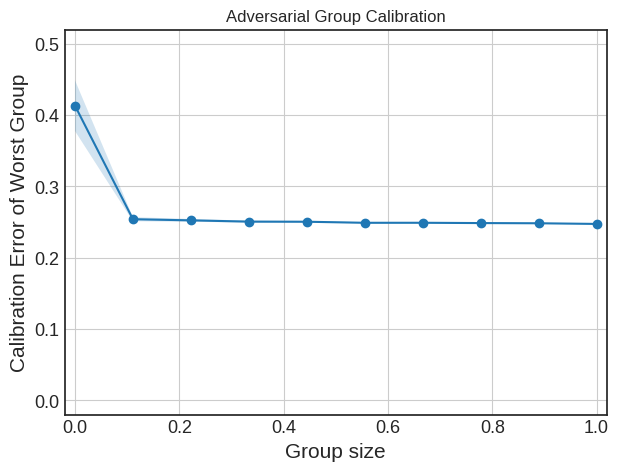

In [ ]:
uct.viz.plot_adversarial_group_calibration(mu_test, var_test, targets_test)
plt.grid()
plt.show()

#Recalibration uncertainity

In [ ]:
targets_val, mu_val, var_val, var_al_val, var_ep_val = calculate_predictions(data_module, model, mode='val')

In [ ]:
np.savez('DER_QM9_val_0.01.npz', preds = mu_val, targets = targets_val, std=var_val, std_al=var_al_val, std_ep=var_ep_val)

0.9999906420707703
0.5465172


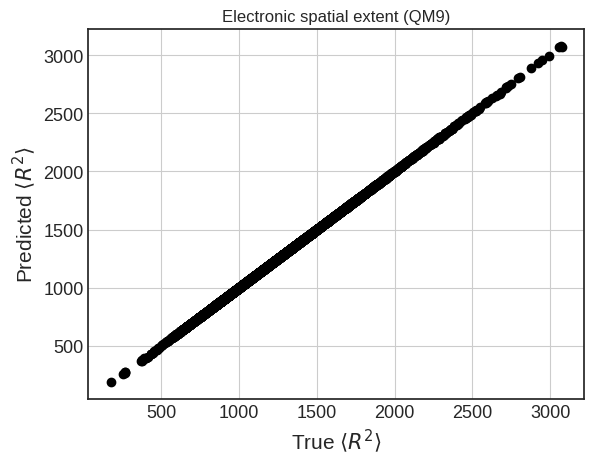

In [ ]:
plt.scatter(targets_val, mu_val, c='k')
print(r2_score(targets_val, mu_val))
print(mean_absolute_error(targets_val, mu_val))
plt.ylabel("Predicted $\langle R^2 \\rangle$")
plt.xlabel("True $\langle R^2 \\rangle$")
plt.grid()
plt.title('Electronic spatial extent (QM9)')
plt.show()

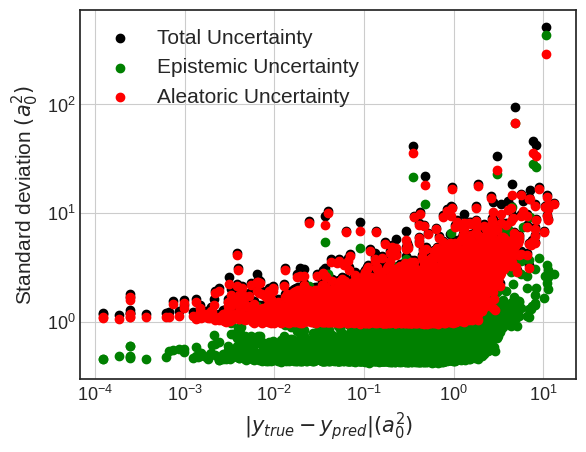

In [ ]:
plt.scatter(np.abs(targets_val - mu_val), var_val, c='k', label='Total Uncertainty')
plt.scatter(np.abs(targets_val - mu_val), var_ep_val, c='g', label='Epistemic Uncertainty')
plt.scatter(np.abs(targets_val - mu_val), var_al_val, c='r', label='Aleatoric Uncertainty')
plt.grid()
plt.xlabel('$|y_{true} - y_{pred}| (a_{0}^2)$')
plt.ylabel('Standard deviation $(a_{0}^2)$')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.savefig('Uncertainty_estimates_QM9_DER.png', dpi=600)

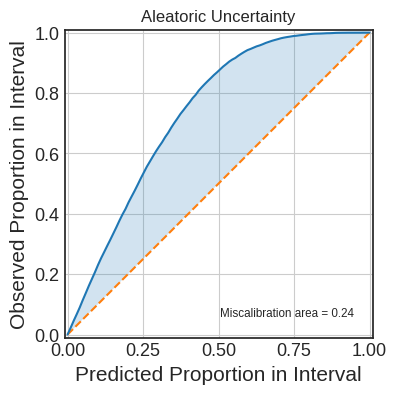

In [ ]:
uct.viz.plot_calibration(mu_val, var_al_val, targets_val)
plt.gcf().set_size_inches(4, 4)
plt.title('Aleatoric Uncertainty')
plt.grid()
plt.show()

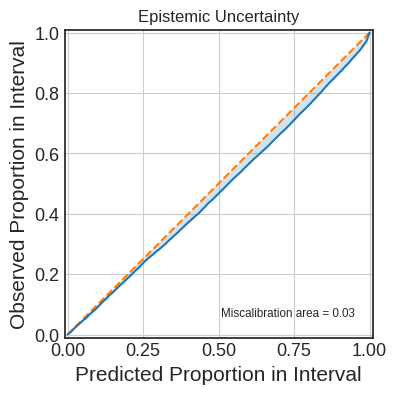

In [ ]:
uct.viz.plot_calibration(mu_val, var_ep_val, targets_val)
plt.gcf().set_size_inches(4, 4)
plt.title('Epistemic Uncertainty')
plt.grid()
plt.show()

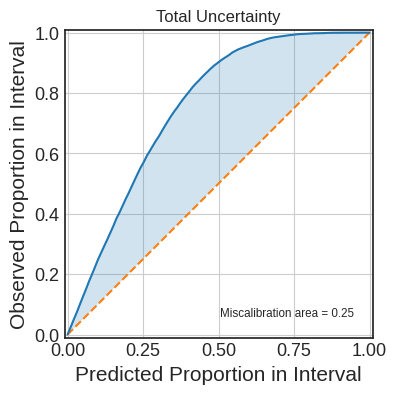

In [ ]:
uct.viz.plot_calibration(mu_val, var_val, targets_val)
plt.gcf().set_size_inches(4, 4)
plt.title('Total Uncertainty')
plt.grid()
plt.show()